In [39]:
import os
from typing import Annotated
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from pydantic import BaseModel
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage,SystemMessage, ToolMessage
from langgraph.types import Command, interrupt
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from dotenv import load_dotenv

In [40]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv('Groq') # type: ignore
os.environ["TAVILY_API_KEY"] = os.getenv('Tavily') # type: ignore

In [41]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""
    question: str

In [42]:
@tool
def search(query: str):
    """Call to surf the web."""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    formatted_results = []
    if isinstance(result, list): 
        for item in result:
            if isinstance(item, dict): 
                title = item.get('title', 'No Title')
                url = item.get('url', 'No URL')
                content = item.get('content', 'No Content')
                # Truncate content for brevity
                truncated_content = (content[:200] + '...') if len(content) > 200 else content
                formatted_results.append(f"Title: {title}\nURL: {url}\nContent: {truncated_content}\n---")
            else:
                formatted_results.append(f"Unexpected item type: {item}")
        formatted_output = "\n".join(formatted_results)
    else:
        formatted_output = str(result) 

    return f"I looked up: {query}.\n\nResults:\n{formatted_output}\n\nBut you better look out if you're a Gemini 😈."


In [43]:
tools = [search]
tool_node = ToolNode(tools)
memory = InMemorySaver()
llm = ChatGroq(model="llama3-8b-8192",temperature=0.5,)
llm_with_tool = llm.bind_tools(tools + [AskHuman])

In [44]:

# chatbot
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tool.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def should_continue(state: State):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # No human feedback needed,continue using tool call
    else:
        return "action"
    
def ask_human(state):
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    # Below line will raise model validation error - if Field in tool_call is "query"
    # Since AskHuman has Field "question", while testing with mock tool_call data
    # it has to refect the same - check test_ask_human_returns_tool_message()
    ask = AskHuman.model_validate(state["messages"][-1].tool_calls[0]["args"])
    # The interrupt should return the question, not store it in a variable
    human_response = interrupt(ask.question)
    # Create tool message with human response
    tool_message = ToolMessage(
        content=human_response,
        tool_call_id=tool_call_id
    )
    return {"messages": [tool_message]}


In [45]:

workflow =  StateGraph(State)

workflow.add_node("agent", call_model) # chatbot
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    path_map=["ask_human", "action", END],
)
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")
# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

app = workflow.compile(checkpointer=memory, interrupt_after=["action"])

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def stream_graph_updates(user_input: str):
    try:
        events = app.stream(
            {"messages": [HumanMessage(content=user_input)]},
            config,
            stream_mode="values",
        )
        
        for event in events:
            if "messages" in event and event["messages"]:
                print(event["messages"][-1].pretty_print())
        
        # Check if we're interrupted after search/action
        state_snapshot = app.get_state(config)
        if state_snapshot.next and state_snapshot.next != [END]:
            # We're interrupted after search - ask human for feedback
            print("\n" + "="*50)
            print("Search completed! What would you like me to do next?")
            print("="*50)
            human_feedback = input(" Your guidance: ")
            # Add human feedback as a new message
            app.update_state(config, {
                "messages": [HumanMessage(content=f"Human feedback: {human_feedback}")]
            })
            # Resume execution
            resumed_events = app.stream(
                None,  # No new input, just resume
                config,
                stream_mode="values"
            )
            for resumed_event in resumed_events:
                if "messages" in resumed_event and resumed_event["messages"]:
                    print(resumed_event["messages"][-1].pretty_print())

    except Exception as e:
        print(f"Error in stream_graph_updates: {e}")
        import traceback
        traceback.print_exc()

In [ ]:

# while True:
#     try:
#         user_input = input("User: ")
#         if user_input.lower() in ["quit", "exit", "q"]:
#             break
#         stream_graph_updates(user_input)
                
#     except KeyboardInterrupt:
#         print("\nExiting...")
#         break
#     except Exception as e:
#         print(f"Error in main loop: {e}")
#         import traceback
#         traceback.print_exc()
#         break

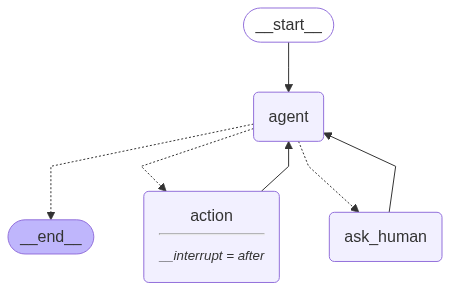

In [47]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

## Testing

In [65]:
import unittest
from unittest.mock import patch, MagicMock
from langchain_core.messages import AIMessage, ToolMessage,HumanMessage
import builtins

#### Model response

In [49]:
def test_call_model_response(user_input):
    state: State = {
        "messages": [HumanMessage(content=user_input)]
    }
    result = call_model(state)
    assert "messages" in result
    assert isinstance(result["messages"][0], AIMessage)
    # assert any(keyword in result["messages"][0].content.lower() for keyword in ["new delhi", "capital"])
    return result

# AIMessage
ai_message = test_call_model_response("What is the capital of India?")

print("ai_message(type) : ",type(ai_message))
print('------')
print("content : ",ai_message["messages"][-1].content)
print('------')
print("additional_kwargs : ",ai_message["messages"][-1].additional_kwargs)
print('------')
print("response_metadata : ",ai_message["messages"][-1].response_metadata)
print('------')
print("id : ",ai_message["messages"][-1].id)
print('------')
print("tool_calls : ",ai_message["messages"][-1].tool_calls)
print('------')
print("usage_metadata : ",ai_message["messages"][-1].usage_metadata)

ai_message(type) :  <class 'dict'>
------
content :  
------
additional_kwargs :  {'tool_calls': [{'id': '6h0qnxbem', 'function': {'arguments': '{"query":"capital of India"}', 'name': 'search'}, 'type': 'function'}]}
------
response_metadata :  {'token_usage': {'completion_tokens': 67, 'prompt_tokens': 975, 'total_tokens': 1042, 'completion_time': 0.059784414, 'prompt_time': 0.108849734, 'queue_time': 0.268808056, 'total_time': 0.168634148}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}
------
id :  run--4a1a4f8f-4f5a-49e3-9685-26a69766d880-0
------
tool_calls :  [{'name': 'search', 'args': {'query': 'capital of India'}, 'id': '6h0qnxbem', 'type': 'tool_call'}]
------
usage_metadata :  {'input_tokens': 975, 'output_tokens': 67, 'total_tokens': 1042}


In [50]:
tool_call_id = ai_message["messages"][-1].tool_calls[-1]["id"]
tool_call_id

'6h0qnxbem'

#### Model + Tool response

In [51]:

def test_call_model_generates_ai_response():
    state = {
        "messages": [HumanMessage(content="What is the capital of India?")]
    }

    with patch.object(llm_with_tool.__class__, "invoke") as mock_invoke:
        mock_invoke.return_value = AIMessage(content="New Delhi is the capital of India.")

        result = call_model(state)

        assert "messages" in result
        assert isinstance(result["messages"][0], AIMessage)
        assert result["messages"][0].content == "New Delhi is the capital of India."
        mock_invoke.assert_called_once_with(state["messages"])
        return result

In [52]:
ai_message_2 = test_call_model_generates_ai_response()
ai_message_2

{'messages': [AIMessage(content='New Delhi is the capital of India.', additional_kwargs={}, response_metadata={})]}

#### AskHuman response

In [53]:

def test_ask_human_returns_tool_message():

    tool_call = {
        "name": "AskHuman",
        "id": tool_call_id,
        "args": {"question": "Please confirm?"}  # not "query" – since AskHuman has question
    }

    mock_message = AIMessage(content="Waiting on you", tool_calls=[tool_call])
    state = {"messages": [mock_message]}

    with patch("__main__.interrupt", return_value="Test Response") as mock_interrupt:
        result = ask_human(state)
        assert "messages" in result
        assert isinstance(result["messages"][0], ToolMessage)
        assert result["messages"][0].tool_call_id == tool_call_id
        assert result["messages"][0].content == "Test Response"
        mock_interrupt.assert_called_once_with("Please confirm?")

    return result

In [54]:
tool_message = test_ask_human_returns_tool_message()
tool_message

{'messages': [ToolMessage(content='Test Response', tool_call_id='6h0qnxbem')]}

#### Routing response

In [55]:
def test_should_continue_end():
    state = {"messages": [AIMessage(content="All done!")]}
    assert should_continue(state)==END

def test_should_continue_ask_human():
    tool_call = {"name": "AskHuman", "id": tool_call_id, "args": {"question": "Confirm?"}}
    state = {"messages": [AIMessage(content="Need human", tool_calls=[tool_call])]}
    assert should_continue(state)=="ask_human"

def test_should_continue_action():
    tool_call = {"name": "search", "id": tool_call_id, "args": {"query": "LangChain"}}
    state = {"messages": [AIMessage(content="Using search", tool_calls=[tool_call])]}
    assert should_continue(state)=="action"

In [56]:
test_should_continue_end()
test_should_continue_ask_human()
test_should_continue_action()

#### Test stream

In [58]:
def test_stream_graph_updates_with_feedback():
    user_input = "Tell me about India"
    
    # Mocked streaming events
    stream_events = [
        {"messages": [MagicMock(pretty_print=lambda: "First AI message")]}
    ]
    resumed_events = [
        {"messages": [MagicMock(pretty_print=lambda: "Resumed AI message after feedback")]}
    ]
    
    # Mocked state snapshot (with next ≠ [END])
    mock_state_snapshot = MagicMock()
    mock_state_snapshot.next = ["something_else"]

    with patch("builtins.input", return_value="Continue with more details"), \
         patch.object(app, "stream", side_effect=[stream_events, resumed_events]), \
         patch.object(app, "get_state", return_value=mock_state_snapshot), \
         patch.object(app, "update_state") as mock_update:

        stream_graph_updates(user_input)
        # # Ensure app.stream was called twice (initial + resumed)
        # assert app.stream.call_count == 2

        # Check update_state was called with human feedback
        mock_update.assert_called_once()
        args, kwargs = mock_update.call_args
        assert "Human feedback: Continue with more details" in str(args[1]["messages"][0].content)
        return args,kwargs,app


In [59]:
args,kwargs,app = test_stream_graph_updates_with_feedback()

First AI message

Search completed! What would you like me to do next?
Resumed AI message after feedback


In [60]:
print(kwargs)
args

{}


({'configurable': {'thread_id': '3'}},
 {'messages': [HumanMessage(content='Human feedback: Continue with more details', additional_kwargs={}, response_metadata={})]})

#### Graph state checking

In [ ]:
class TestGraphStreaming(unittest.TestCase):
    @patch("__main__.app.update_state")
    @patch("__main__.app.get_state")
    @patch("__main__.app.stream")
    def test_stream_graph_updates(self, mock_stream, mock_get_state, mock_update_state):
        mock_stream.side_effect = [
            iter([{"messages": [MagicMock(content="First response", pretty_print=lambda: "First response")]}]),
            iter([{"messages": [MagicMock(content="Second response", pretty_print=lambda: "Second response")]}]),
        ]
        mock_get_state.return_value = MagicMock(next=["search_complete"])

        with patch("builtins.input", return_value="Continue"):
            stream_graph_updates("What is the capital of India?")

        self.assertEqual(mock_stream.call_count, 2)
        mock_update_state.assert_called_once()

In [62]:
test_case = TestGraphStreaming()
test_case.test_stream_graph_updates()

First response

Search completed! What would you like me to do next?
Second response


In [63]:
print(app.stream)
print(app.get_subgraphs)
print(app.with_config)
print(app.OutputType)
print(app.output_schema)
print(app.output_channels)
print(app.get_state_history)

<bound method Pregel.stream of <langgraph.graph.state.CompiledStateGraph object at 0x00000234A59D4C90>>
<bound method Pregel.get_subgraphs of <langgraph.graph.state.CompiledStateGraph object at 0x00000234A59D4C90>>
<bound method Pregel.with_config of <langgraph.graph.state.CompiledStateGraph object at 0x00000234A59D4C90>>
None
<class 'langgraph.utils.pydantic.LangGraphOutput'>
['messages']
<bound method Pregel.get_state_history of <langgraph.graph.state.CompiledStateGraph object at 0x00000234A59D4C90>>


In [ ]:
#